This is the example script of Readme.md in the Pypi hana-ml project.

In [1]:
# Connection
from hana_ml.dataframe import ConnectionContext, create_dataframe_from_pandas

conn = ConnectionContext(address="lsvxc0103.sjc.sap.corp",
                         port=30315,
                         user="PAL_TEST",
                         password="Init12345")

In [2]:
import pandas as pd
from hana_ml.dataframe import create_dataframe_from_pandas
data_list_fit = [('Sunny', 75.0, 70.0, 'Yes', 'Play'), ('Sunny', 80.0, 90.0, 'Yes', 'Do not Play'),
                     ('Sunny', 85.0, 85.0, 'No', 'Do not Play'), ('Sunny', 72.0, 95.0, 'No', 'Do not Play'),
                     ('Sunny', 69.0, 70.0, 'No', 'Play'), ('Overcast', 72.0, 90.0, 'Yes', 'Play'),
                     ('Overcast', 83.0, 78.0, 'No', 'Play'), ('Overcast', 64.0, 65.0, 'Yes', 'Play'),
                     ('Overcast', 81.0, 75.0, 'No', 'Play'), ('Rain', 71.0, 80.0, 'Yes', 'Do not Play'),
                     ('Rain', 65.0, 70.0, 'Yes', 'Do not Play'), ('Rain', 75.0, 80.0, 'No', 'Play'),
                     ('Rain', 68.0, 80.0, 'No', 'Play'), ('Rain', 70.0, 96.0, 'No', 'Play')]

data_list_predict = [
    (0, 'Overcast', 75.0, 70.0, 'Yes'), (1, 'Rain', 78.0, 70.0, 'Yes'),
    (2, 'Sunny', 66.0, 70.0, 'Yes'), (3, 'Sunny', 69.0, 70.0, 'Yes'),
    (4, 'Rain', None, 70.0, 'Yes'), (5, None, 70.0, 70.0, 'Yes'),
    (6, '***', 70.0, 70.0, 'Yes')]

data_list_score = [
    (0, 'Sunny', 75.0, 70.0, 'Yes', 'Play'), (1, 'Sunny', None, 90.0, 'Yes', 'Do not Play'),
    (2, 'Sunny', 85.0, None, 'No', 'Do not Play'), (3, 'Sunny', 72.0, 95.0, 'No', 'Do not Play'),
    (4, None, None, 70.0, None, 'Play'), (5, 'Overcast', 72.0, 90.0, 'Yes', 'Play'),
    (6, 'Overcast', 83.0, 78.0, 'No', 'Play'), (7, 'Overcast', 64.0, 65.0, 'Yes', 'Do not Play'),
    (8, 'Overcast', 81.0, 75.0, 'No', 'Play')]

df_fit = create_dataframe_from_pandas(connection_context=conn,
                                      pandas_df=pd.DataFrame(data_list_fit, 
                                                             columns=["OUTLOOK", "TEMP", "HUMIDITY", "WINDY", "CLASS"]),
                                      table_name="PAL_FIT_TBL",
                                      force=True)
df_predict = create_dataframe_from_pandas(connection_context=conn,
                                      pandas_df=pd.DataFrame(data_list_predict, 
                                                             columns=["ID", "OUTLOOK", "TEMP", "HUMIDITY", "WINDY"]),
                                      table_name="PAL_PREDICT_TBL",
                                      force=True)
df_score = create_dataframe_from_pandas(connection_context=conn,
                                      pandas_df=pd.DataFrame(data_list_score, 
                                                             columns=["ID", "OUTLOOK", "TEMP", "HUMIDITY", "WINDY", "CLASS"]),
                                      table_name="PAL_SCORE_TBL",
                                      force=True)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.13it/s]


In [3]:
df_fit = df_fit.add_id('ID')
print(df_fit.head(5).collect())
print(df_predict.head(5).collect())
print(df_score.head(5).collect())

   ID OUTLOOK  TEMP  HUMIDITY WINDY        CLASS
0   1   Sunny  75.0      70.0   Yes         Play
1   2   Sunny  80.0      90.0   Yes  Do not Play
2   3   Sunny  85.0      85.0    No  Do not Play
3   4   Sunny  72.0      95.0    No  Do not Play
4   5   Sunny  69.0      70.0    No         Play
   ID   OUTLOOK  TEMP  HUMIDITY WINDY
0   0  Overcast  75.0      70.0   Yes
1   1      Rain  78.0      70.0   Yes
2   2     Sunny  66.0      70.0   Yes
3   3     Sunny  69.0      70.0   Yes
4   4      Rain   NaN      70.0   Yes
   ID OUTLOOK  TEMP  HUMIDITY WINDY        CLASS
0   0   Sunny  75.0      70.0   Yes         Play
1   1   Sunny   NaN      90.0   Yes  Do not Play
2   2   Sunny  85.0       NaN    No  Do not Play
3   3   Sunny  72.0      95.0    No  Do not Play
4   4    None   NaN      70.0  None         Play


In [4]:
import matplotlib
print(matplotlib.__version__)

3.3.4


In [5]:
from hana_ml.visualizers.unified_report import UnifiedReport
UnifiedReport(df_fit).build().display()

Generating dataset report...: 100%|███████████████████████████████████| 4/4 [00:28<00:00,  7.15s/it]
In order to review the dataset report better, you need to adjust the size of the left area or hide the left area temporarily!


In [6]:
from hana_ml.algorithms.pal.unified_classification import UnifiedClassification
rdt_params = dict(random_state=2,
                  split_threshold=1e-7,
                  min_samples_leaf=1,
                  n_estimators=10,
                  max_depth=55)
uc_rdt = UnifiedClassification(func = 'RandomDecisionTree', **rdt_params)

uc_rdt.fit(data=df_fit, key = 'ID', partition_method='stratified',
           stratified_column='CLASS', partition_random_state=2,
           training_percent=0.7, ntiles=2, build_report=True)
print(uc_rdt.importance_.collect())

  VARIABLE_NAME  IMPORTANCE
0       OUTLOOK    0.191748
1          TEMP    0.418285
2      HUMIDITY    0.389968
3         WINDY    0.000000


In [7]:
res = uc_rdt.predict(df_predict, key = "ID", top_k_attributions=10)
print(res.collect())

   ID SCORE  CONFIDENCE                                        REASON_CODE
0   0  Play         0.8  [{"attr":"OUTLOOK","pct":55.0,"val":0.16},{"at...
1   1  Play         0.6  [{"attr":"TEMP","pct":63.0,"val":-0.1375000000...
2   2  Play         1.0  [{"attr":"HUMIDITY","pct":45.0,"val":0.2049999...
3   3  Play         1.0  [{"attr":"HUMIDITY","pct":45.0,"val":0.2049999...
4   4  Play         0.6  [{"attr":"TEMP","pct":63.0,"val":-0.1375000000...
5   5  Play         0.6  [{"attr":"HUMIDITY","pct":43.0,"val":0.1799999...
6   6  Play         0.6  [{"attr":"HUMIDITY","pct":43.0,"val":0.1799999...


1.Using Shapley values to show the distribution of the impacts each feature has on the model output.
2.The color represents the feature value (red high, blue low).
3.The plot below shows the relationship between feature value and Shapley value.
-- If the dots in the left area are blue and the dots in the right area are red, then it means that the feature value and the Shapley value are typically positive correlation.
-- If the dots in the left area are red and the dots in the right area are blue, then it means that the feature value and the Shapley value are typically negative correlation.
-- If all the dots are concentrated near 0, it means that the Shapley value has nothing to do with this feature.


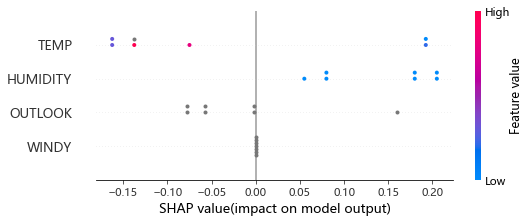

In [8]:
from hana_ml.visualizers.model_debriefing import TreeModelDebriefing
shapley_explainer = TreeModelDebriefing.shapley_explainer(res, df_predict, key='ID', label='')
shapley_explainer.summary_plot()

In [9]:
score_res = uc_rdt.score(df_score,
                         key='ID',
                         max_result_num=2,
                         ntiles=2,
                         attribution_method='tree-shap')[1].head(4)

In [10]:
print(score_res.collect())

   STAT_NAME          STAT_VALUE   CLASS_NAME
0        AUC  0.8024691358024691         None
1     RECALL                0.75  Do not Play
2  PRECISION                   1  Do not Play
3   F1_SCORE  0.8571428571428571  Do not Play


In [11]:
UnifiedReport(uc_rdt).build().display()

In order to review the unified classification model report better, you need to adjust the size of the left area or hide the left area temporarily!


In [12]:
conn.close()